In [1]:
from data_generator import *
vis_text, vis_raw_audio, vis_mfcc_feature, vis_spectrogram_feature, vis_audio_path = vis_train_features()


There are 4105 total training examples.


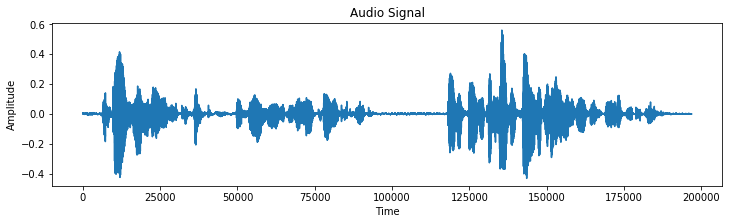

**Shape of Audio Signal** : (196907,)

**Transcript** : it galled him however to think that he and his were so poorly dressed i am afraid you can hardly find a chair miss robarts said mister crawley

In [2]:
from IPython.display import Markdown, display
from IPython.display import Audio
%matplotlib inline

# plot audio signal
plot_raw_audio(vis_raw_audio)
# print length of audio signal
display(Markdown('**Shape of Audio Signal** : ' + str(vis_raw_audio.shape)))
# print transcript corresponding to audio clip
display(Markdown('**Transcript** : ' + str(vis_text)))
# play the audio file
Audio(vis_audio_path)

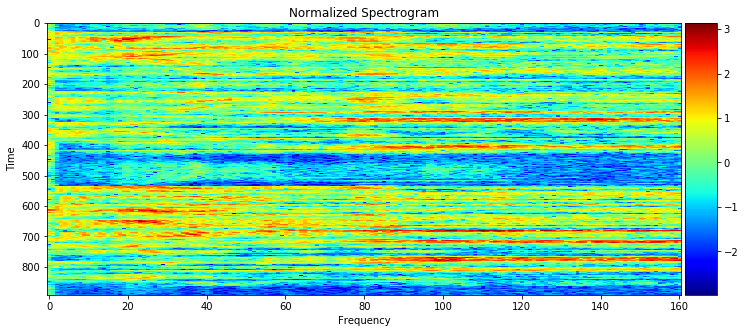

**Shape of Spectrogram** : (892, 161)

In [3]:
from data_generator import plot_spectrogram_feature

# plot normalized spectrogram
plot_spectrogram_feature(vis_spectrogram_feature)
# print shape of spectrogram
display(Markdown('**Shape of Spectrogram** : ' + str(vis_spectrogram_feature.shape)))

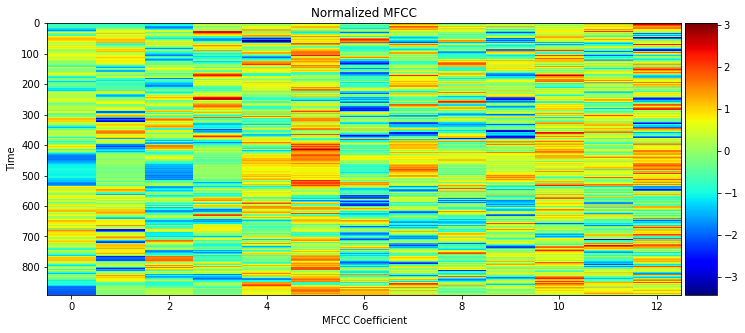

**Shape of MFCC** : (892, 13)

In [4]:
from data_generator import plot_mfcc_feature

# plot normalized MFCC
plot_mfcc_feature(vis_mfcc_feature)
# print shape of MFCC
display(Markdown('**Shape of MFCC** : ' + str(vis_mfcc_feature.shape)))

In [5]:
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.98
set_session(tf.Session())

%load_ext autoreload
%autoreload 2
from sample_models import *
# import function for training acoustic model
from train_utils import train_model

/home/whusym/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
model_1 = rnn_model(input_dim=13, # change to 13 if you would like to use MFCC features
                    units=200,
                    activation='relu')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
rnn (GRU)                    (None, None, 200)         128400    
_________________________________________________________________
bn_rnn (BatchNormalization)  (None, None, 200)         800       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 135,029
Trainable params: 134,629
Non-trainable params: 400
_________________________________________________________________
None


In [ ]:
train_model(input_to_softmax=model_1, 
            pickle_path='model_1.pickle', 
            save_model_path='model_1.h5',
            spectrogram=False, 
            epochs=25)

Epoch 1/25
205/205 [==============================] - 282s 1s/step - loss: 281.5419 - val_loss: 251.4099
Epoch 2/25
205/205 [==============================] - 251s 1s/step - loss: 217.2719 - val_loss: 221.5595
Epoch 3/25
205/205 [==============================] - 242s 1s/step - loss: 187.2412 - val_loss: 187.0601
Epoch 4/25
205/205 [==============================] - 254s 1s/step - loss: 172.0879 - val_loss: 172.2386
Epoch 5/25
205/205 [==============================] - 256s 1s/step - loss: 162.7736 - val_loss: 171.6140
Epoch 6/25
205/205 [==============================] - 241s 1s/step - loss: 156.7257 - val_loss: 160.2508
Epoch 7/25
205/205 [==============================] - 241s 1s/step - loss: 152.4845 - val_loss: 157.1409
Epoch 8/25
205/205 [==============================] - 242s 1s/step - loss: 148.6893 - val_loss: 154.5244
Epoch 9/25
205/205 [==============================] - 244s 1s/step - loss: 146.1573 - val_loss: 150.0655
Epoch 10/25
205/205 [==============================] - 

In [ ]:
model_4 = bidirectional_rnn_model(input_dim=13, # change to 13 if you would like to use MFCC features
                                  units=200)

In [ ]:
train_model(input_to_softmax=model_4, 
            pickle_path='model_4.pickle', 
            save_model_path='model_4.h5', 
            spectrogram=False,
            epochs=25) # change to False if you would like to use MFCC features

In [6]:
import swig_decoders

In [17]:
class Scorer(swig_decoders.Scorer):
    """Wrapper for Scorer.

    :param alpha: Parameter associated with language model. Don't use
                  language model when alpha = 0.
    :type alpha: float
    :param beta: Parameter associated with word count. Don't use word
                 count when beta = 0.
    :type beta: float
    :model_path: Path to load language model.
    :type model_path: basestring
    """

    def __init__(self, alpha, beta, model_path, vocabulary):
        swig_decoders.Scorer.__init__(self, alpha, beta, model_path, vocabulary)

        
def ctc_beam_search_decoder_batch(probs_split,
                                  vocabulary,
                                  beam_size,
                                  num_processes,
                                  cutoff_prob=1.0,
                                  cutoff_top_n=40,
                                  ext_scoring_func=None):
    """Wrapper for the batched CTC beam search decoder.

    :param probs_seq: 3-D list with each element as an instance of 2-D list
                      of probabilities used by ctc_beam_search_decoder().
    :type probs_seq: 3-D list
    :param vocabulary: Vocabulary list.
    :type vocabulary: list
    :param beam_size: Width for beam search.
    :type beam_size: int
    :param num_processes: Number of parallel processes.
    :type num_processes: int
    :param cutoff_prob: Cutoff probability in vocabulary pruning,
                        default 1.0, no pruning.
    :type cutoff_prob: float
    :param cutoff_top_n: Cutoff number in pruning, only top cutoff_top_n
                         characters with highest probs in vocabulary will be
                         used in beam search, default 40.
    :type cutoff_top_n: int
    :param num_processes: Number of parallel processes.
    :type num_processes: int
    :param ext_scoring_func: External scoring function for
                             partially decoded sentence, e.g. word count
                             or language model.
    :type external_scoring_function: callable
    :return: List of tuples of log probability and sentence as decoding
             results, in descending order of the probability.
    :rtype: list
    """
    probs_split = [probs_seq.tolist() for probs_seq in probs_split]

    batch_beam_results = swig_decoders.ctc_beam_search_decoder_batch(
        probs_split, vocabulary, beam_size, num_processes, cutoff_prob,
        cutoff_top_n, ext_scoring_func)
    batch_beam_results = [
#         [(res[0], res[1].decode("utf-8")) for res in beam_results]
        [(res[0], res[1]) for res in beam_results]
        for beam_results in batch_beam_results
    ]
    return batch_beam_results


def ctc_beam_search_decoder(probs_seq,
                            vocabulary,
                            beam_size,
                            cutoff_prob=1.0,
                            cutoff_top_n=40,
                            ext_scoring_func=None):
    """Wrapper for the CTC Beam Search Decoder.

    :param probs_seq: 2-D list of probability distributions over each time
                      step, with each element being a list of normalized
                      probabilities over vocabulary and blank.
    :type probs_seq: 2-D list
    :param vocabulary: Vocabulary list.
    :type vocabulary: list
    :param beam_size: Width for beam search.
    :type beam_size: int
    :param cutoff_prob: Cutoff probability in pruning,
                        default 1.0, no pruning.
    :type cutoff_prob: float
    :param cutoff_top_n: Cutoff number in pruning, only top cutoff_top_n
                         characters with highest probs in vocabulary will be
                         used in beam search, default 40.
    :type cutoff_top_n: int
    :param ext_scoring_func: External scoring function for
                             partially decoded sentence, e.g. word count
                             or language model.
    :type external_scoring_func: callable
    :return: List of tuples of log probability and sentence as decoding
             results, in descending order of the probability.
    :rtype: list
    """
    beam_results = swig_decoders.ctc_beam_search_decoder(
        probs_seq.tolist(), vocabulary, beam_size, cutoff_prob, cutoff_top_n,
        ext_scoring_func)
#     beam_results = [(res[0], res[1].decode('utf-8')) for res in beam_results]
    beam_results = [(res[0], res[1]) for res in beam_results]
    return beam_results


In [9]:
vocab = ["'", ' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [29]:
vocab_num = list(range(29))

In [10]:
loaded = np.loadtxt('savedArray1.txt')

In [11]:
loaded.shape
len(vocab)

28

In [13]:
lm = init_ext_scorer('/home/whusym/DeepSpeech/models/lm/common_crawl_00.prune01111.trie.klm', vocab)

In [27]:
def init_ext_scorer(language_model_path,
                    vocab_list, beam_alpha=5, beam_beta=1):
    """Initialize the external scorer.

    :param beam_alpha: Parameter associated with language model.
    :type beam_alpha: float
    :param beam_beta: Parameter associated with word count.
    :type beam_beta: float
    :param language_model_path: Filepath for language model. If it is
                                empty, the external scorer will be set to
                                None, and the decoding method will be pure
                                beam search without scorer.
    :type language_model_path: basestring|None
    :param vocab_list: List of tokens in the vocabulary, for decoding.
    :type vocab_list: list
    """
    if language_model_path != '':
#         self.logger.info("begin to initialize the external scorer "
#                          "for decoding")
        _ext_scorer = Scorer(beam_alpha, beam_beta, language_model_path, vocab_list)
        lm_char_based = _ext_scorer.is_character_based()
        lm_max_order = _ext_scorer.get_max_order()
        lm_dict_size = _ext_scorer.get_dict_size()
#         self.logger.info("language model: "
#                          "is_character_based = %d," % lm_char_based +
#                          " max_order = %d," % lm_max_order +
#                          " dict_size = %d" % lm_dict_size)
#         self.logger.info("end initializing scorer")
    else:
        _ext_scorer = None
#         self.logger.info("no language model provided, "
#                          "decoding by pure beam search without scorer.")


In [30]:
batch_res = ctc_beam_search_decoder(loaded, vocab, 30, ext_scoring_func=lm)


True transcription:

even in middle age they were still comely and the old grey haired women at their cottage doors had a dignity not to say majesty of their own

Predicted transcription:

even in mit la aton he wersti cimlyand the od gadyhar whamanather candors ad ad dagken eatdesi rageste ather omn


In [31]:
batch_res


[(98.94906616210938,
  'even in mit la aton he wersti cimly and the od gady hard whamanather cade dors ad ad dagh en eatdesi rageste ather omn'),
 (98.95468139648438,
  'even in mit la aton he wersti cimly and the od gady hard whamana ther cade dors ad ad dagh en eatdesi rageste ather omn'),
 (98.9559326171875,
  'even in mit la aton he wersti cimly and the old gady hard whamanather cade dors ad ad dagh en eatdesi rageste ather omn'),
 (98.9615478515625,
  'even in mit la aton he wersti cimly and the old gady hard whamana ther cade dors ad ad dagh en eatdesi rageste ather omn'),
 (99.07732391357422,
  'even in mit la aton he wersti cimly and the od gady hard whamanather cade dors ad ad dagh en eatdesi rageste other omn'),
 (99.08293914794922,
  'even in mit la aton he wersti cimly and the od gady hard whamana ther cade dors ad ad dagh en eatdesi rageste other omn'),
 (99.08419036865234,
  'even in mit la aton he wersti cimly and the old gady hard whamanather cade dors ad ad dagh en eat